# ANALYSE D'INDICATEURS SUR LA VIE SCOLAIRE ET EXTRA-SCOLAIRE DES ÉLÈVES DE L'INSA TOULOUSE

### I. Objectif

Avec pour objectif d'aider tous les étudiants admis à obtenir leur diplôme quelle que soit leur origine sociale ou géographique, ou leur parcours scolaire avant d'entrer à l'INSA. Nous souhaitons donc pouvoir connaître les facteurs qui peuvent affecter la capacité de réussitte des étudiants afin de pouvoir trouver des solutions pour améliorer le taux de réussite des étudiants de l'INSA Toulouse.

    Modélisation du problème :
    Tout d'abord, dans le but que tous les étudiants obtiennent leur diplôme, nous allons étudier la variable REDOUBLEMENT par d'autres variables (facteurs affectant les étudiants). Pour les étudiants encore à l'école, cette variable décrit le mieux la probabilité de finir leurs études ou non. Nous voulons identifier les facteurs influençant le redoublement afin de limiter ce phénomène et d'améliorer le taux d'étudiants obtenant leur diplôme ou le faisant dans les délais impartis.
    De plus, nous pouvons étudier la variable RATTRAPAGES pour trouver des moyens de limiter les examens de rattrapage ou utiliser la variable CLASSEMENTDERNIER pour examiner quels facteurs aident les étudiants à obtenir de meilleurs résultats. 
    
    
**Cependant**, le problème se pose pour la variable CLASSEMENTDERNIER où environ un tiers choisissent "Je ne sais pas", ce qui complique le traitement car nous manquons d'informations et, si nous supprimons ces réponses, nous perdons un grand nombre d'observations. De plus, il est très difficile d'obtenir des informations pour les étudiants de première année ou les nouveaux entrants car lors de cette enquête, nous étions au deuxième semestre de l'année scolaire, ce qui signifie qu'ils n'ont passé qu'un semestre. Par conséquent, ils n'ont pas de résultats pour REDOUBLEMENT ou CLASSEMENTDERNIER, et la variable RATTRAPAGES, qui représente la moyenne du nombre de redoublements pendant toute la durée des études, est basée sur un échantillon trop petit. Je pense qu'il serait peut-être possible de séparer ces étudiants dans un jeu de données distinct, et nous analyserions alors les facteurs influençant leur capacité à s'adapter et à s'intégrer aux études à l'INSA Toulouse.
    

## II. Préparer les données.

### II.1. Découvrir des données 
Nous avons les données collectées d'une enquête réalisée par des étudiants de l'INSA Toulouse en mai 2024, effectuée via l'application Limesurvey. Ensuite, nous avons un fichier Excel contenant des lignes représentant chaque étudiant et des colonnes correspondant aux réponses. De plus, nous avons un fichier PDF 'Statistiques rapides' décrivant la distribution des réponses pour chaque question, ce qui nous aide à obtenir une vision plus détaillée des questions et des données que nous avons.

### II.2. Transformer des données 

Comme la plupart des questions sont à choix multiples, la réponse à une question ne se trouve pas dans une colonne mais dans plusieurs colonnes. Nous devons donc convertir ces colonnes en une seule colonne.

À cette étape, je me suis basé sur les résultats du fichier Excel des trois membres de l'équipe qui ont travaillé sur le projet précédent. Nous utilisons une formule conditionnelle dans Excel ; si la valeur de la colonne est "oui", elle renverra le résultat correspondant à la valeur de cette colonne. Cependant, après vérification, j'ai constaté qu'ils n'ont pas pris en compte les données de certaines questions, comme COMMENTAIRE, COURSNOTES(TD), COURSNOTES(TP), CONCENTRATIONPERSO, LOISIRSIMPACT, PREPMETIER, DOUBLEDIPLOME. Ils ont expliqué que cela était dû au fait qu'ils estimaient que ces variables pouvaient avoir une forte corrélation avec une autre variable, ou que ces variables avaient un taux élevé de valeurs non affichées, ou que tous les résultats se concentraient sur une seule valeur, etc. Mais je pense que cela n'est qu'une partie de leur ressenti, car ils n'ont pas utilisé de méthodes théoriques pour vérifier. Je souhaite donc utiliser tous les résultats des questions du sondage, vérifier le taux de données manquantes ou la corrélation des variables, puis les traiter ensuite.


En outre, pour les questions avec des valeurs de choix "Autre", où les répondants devaient entrer leur propre réponse, comme pour LOGEMENTTYPE, nous avons remarqué qu'il n'y avait pas beaucoup de valeurs "Autre". Nous avons donc regroupé manuellement ces valeurs "Autre" en catégories existantes. Par exemple, "concubinage", "avec ma copine", "en couple", "avec mon frère", "chez un ami" ont été regroupés sous "colocation", et "CROUS", "Logement étudiant", "maison individuelle" ont été regroupés sous "seul".

De plus, pour la variable DOUBLEDIPLOME, je recode les réponses choisies "Autre" en "Oui" ou "Non". Pour les cas indiquant une demande en cours, un souhait d'étudier ou une intention d'étudier l'année prochaine, je les recode en "Non". Selon moi, notre étude se base sur la variable RATTRAPPAGES, la moyenne du nombre de redoublements des semestres déjà étudiés. Par conséquent, si la double diplomation est envisagée dans le futur, cela n'a pas encore d'impact sur la variable cible.

Voici les résultats obtenus après le traitement des données sur Excel. Le fichier comprend 60 colonnes correspondant à 60 variables (sans compter la colonne ID) et 1182 lignes correspondant aux réponses de 1182 étudiants.


In [1]:
library(readxl) #Pour lire le fichier Excel
library(dplyr) #Pour convertir les variables de type 'chr' en type 'factor'
library(ggplot2) #Pour créer des graphiques
library(rlang) #Pour l'évaluation tidyeval
library(gridExtra) # Pour arranger plusieurs graphiques dans une grille
library(ggcorrplot) #Pour visualiser la matrice de corrélation.
library(reshape2) #Pour manipuler les données
library(writexl)
library(randomForest)
library(caret)  # For cross-validation



Attachement du package : ‘dplyr’


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union



Attachement du package : ‘rlang’


L'objet suivant est masqué depuis ‘package:base’:

    %||%



Attachement du package : ‘gridExtra’


L'objet suivant est masqué depuis ‘package:dplyr’:

    combine


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attachement du package : ‘randomForest’


L'objet suivant est masqué depuis ‘package:gridExtra’:

    combine


L'objet suivant est masqué depuis ‘package:ggplot2’:

    margin


L'objet suivant est masqué depuis ‘package:dplyr’:

    combine


Le chargement a nécessité le package : lattice



In [2]:
# Lire le fichier Excel "results-survey278778.xlsx" qui se trouve dans le même répertoire que le script R
insa <- read_excel("survey_Luan.xlsx")
# Sélectionner les 60 variables
insa <- insa[, 2:61]


In [3]:
# Afficher la taille du dataframe
print(dim(insa))

[1] 1182   60


In [4]:
# Afficher les premières lignes du dataframe
print(str(insa))

tibble [1,182 × 60] (S3: tbl_df/tbl/data.frame)
 $ TRAJET            : chr [1:1182] "15-30min" "5-15min" "0-5min" "5-15min" ...
 $ LOGEMENTTYPE      : chr [1:1182] "seul" "seul" "seul" "seul" ...
 $ LOGEMENTSURFACE   : chr [1:1182] "+ 30m2" "+ 30m2" "10-20m2" "+ 30m2" ...
 $ LOGEMENTBIEN      : chr [1:1182] "tout à fait" "tout à fait" "plutôt oui" "tout à fait" ...
 $ ACT_PRO           : chr [1:1182] "aucune" "aucune" "aucune" "aucune" ...
 $ BOURSIER          : chr [1:1182] "echelon 1-3" "non" "non" "non" ...
 $ HANDICAP          : chr [1:1182] "non" "non" "non" "non" ...
 $ TIERSTEMPS        : chr [1:1182] "Non" "Non" "Non" "Non" ...
 $ STRESS            : chr [1:1182] "souvent" "souvent" "souvent" "toujours" ...
 $ COMMENTAIRE       : chr [1:1182] "jamais" "parfois" "parfois" "parfois" ...
 $ COMCONSTRUCTIFS   : chr [1:1182] "pas commentaire" "plutôt oui" "plutôt oui" "plutôt oui" ...
 $ ETUDE_SEM         : chr [1:1182] "0-1h" "+4h" "1-2h" "1-2h" ...
 $ ETUDEWE           : chr [1:11

    Nous constatons que les valeurs des variables sont encodées sous forme de chr[] alors que nos données devraient être encodées sous forme de facteurs pour les variables qualitatives. Par conséquent, nous allons convertir toutes les variables en facteurs.

In [5]:
# Convertir toutes les colonnes de type 'chr' en 'factor' avec dplyr
insa <- insa %>%
  mutate_if(is.character, as.factor)
# Afficher la structure du dataframe après convertir
print(str(insa))

tibble [1,182 × 60] (S3: tbl_df/tbl/data.frame)
 $ TRAJET            : Factor w/ 4 levels "+30min","0-5min",..: 3 4 2 4 4 4 3 3 2 2 ...
 $ LOGEMENTTYPE      : Factor w/ 3 levels "colocation","foyer familial",..: 3 3 3 3 1 1 3 3 3 3 ...
 $ LOGEMENTSURFACE   : Factor w/ 5 levels "- 10m2","+ 30m2",..: 2 2 3 2 5 5 4 2 3 4 ...
 $ LOGEMENTBIEN      : Factor w/ 4 levels "pas du tout",..: 4 4 3 4 4 4 4 4 3 3 ...
 $ ACT_PRO           : Factor w/ 5 levels "aucune","oui +15h",..: 1 1 1 1 1 3 1 2 1 1 ...
 $ BOURSIER          : Factor w/ 4 levels "echelon 0bis",..: 2 4 4 4 4 4 4 4 1 4 ...
 $ HANDICAP          : Factor w/ 2 levels "non","oui": 1 1 1 1 1 1 1 1 1 2 ...
 $ TIERSTEMPS        : Factor w/ 2 levels "Non","Oui": 1 1 1 1 2 1 1 1 1 2 ...
 $ STRESS            : Factor w/ 4 levels "jamais","parfois",..: 3 3 3 4 3 4 4 3 3 3 ...
 $ COMMENTAIRE       : Factor w/ 4 levels "jamais","parfois",..: 1 2 2 2 2 2 2 2 2 3 ...
 $ COMCONSTRUCTIFS   : Factor w/ 5 levels "non","pas commentaire",..: 2 4 4 4 4 4

    Nous constatons que les variables ont été converties en facteurs, mais l'ordre des modalités est mélangé. Cela rend le suivi de chaque variable difficile et je trouve cela déroutant. Par conséquent, nous devons convertir la variable en facteur avec un ordre spécifique.

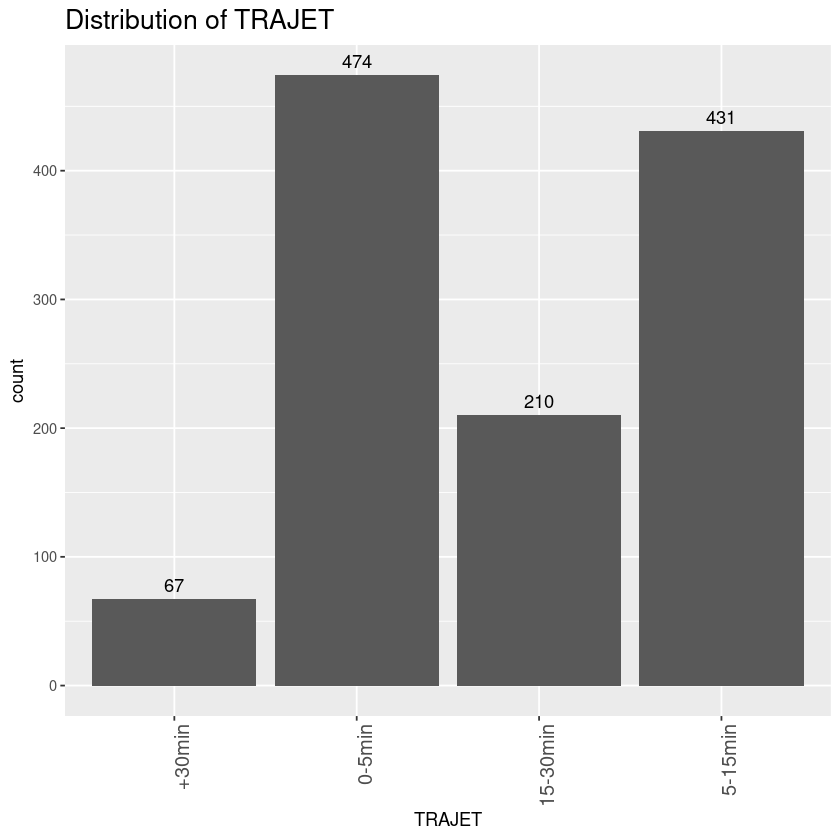

In [6]:
# Créer le graphique de distribution pour la variable TRAJET
p <- ggplot(insa, aes(x = TRAJET)) +
  geom_bar() +
  geom_text(stat='count', aes(label=after_stat(count)), vjust=-0.5) +
  ggtitle("Distribution of TRAJET") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 12),
        plot.title = element_text(size = 16))

# Afficher le graphique
print(p)

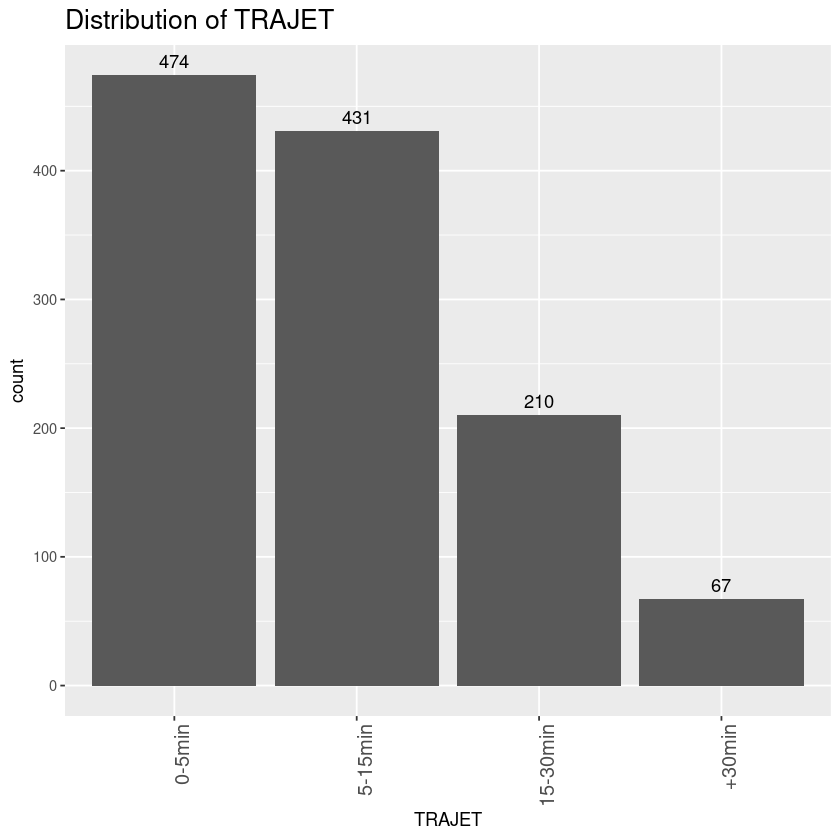

In [7]:
# Convertir la variable en facteur avec un ordre spécifique
insa$TRAJET <- factor(insa$TRAJET, levels = c("0-5min", "5-15min", "15-30min", "+30min"))

# Créer le graphique de distribution pour la variable TRAJET
p <- ggplot(insa, aes(x = TRAJET)) +
  geom_bar() +
  geom_text(stat='count', aes(label=after_stat(count)), vjust=-0.5) +
  ggtitle("Distribution of TRAJET") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 12),
        plot.title = element_text(size = 16))

# Afficher le graphique
print(p)

    Nous procéderons de la même manière pour toutes les variables.

In [8]:
levels_list <- list(
  TRAJET = c("0-5min", "5-15min", "15-30min", "+30min"),
  LOGEMENTTYPE = c("seul", "colocation", "foyer familial"),
  LOGEMENTSURFACE = c("- 10m2", "10-20m2", "20-30m2", "+ 30m2","coloc ou foyer familial"),
  LOGEMENTBIEN = c("pas du tout", "plutôt non", "plutôt oui", "tout à fait"),
  ACT_PRO = c("aucune", "oui 1-5h", "oui 5-10h","oui 10-15h", "oui +15h"),
  BOURSIER = c("non","echelon 0bis", "echelon 1-3", "echelon 4-7"),
  HANDICAP = c("non", "oui"),
  TIERSTEMPS = c("Non", "Oui"),
  STRESS = c("jamais", "parfois", "souvent", "toujours"),
  COMMENTAIRE = c("jamais", "parfois", "souvent", "toujours"),
  COMCONSTRUCTIFS = c("pas commentaire","non", "plutôt non", "plutôt oui", "tout à fait"),
  ETUDE_SEM = c("0h", "0-1h", "1-2h", "2-4h", "+4h"),
  ETUDEWE = c("0h","0-1h","1-2h", "2-4h", "4-6h", "6-8h", "+8h"),
  ETUDEGROUPE = c("jamais", "parfois", "souvent", "toujours"),
  ETUDEDEHORS = c("jamais", "parfois", "souvent", "toujours"),
  ETUDEDOM = c("jamais", "parfois", "souvent", "toujours"),
  PRESENCE_CM = c("Jamais", "Parfois", "Souvent", "Toujours"),
  PRESENCE_TD = c("Jamais", "Parfois", "Souvent", "Toujours"),
  PRESENCE_TP = c("Jamais", "Parfois", "Souvent", "Toujours"),
  CONCENTRATION_CM = c("Très peu concentré.e", "Moyennement concentré.e", "Assez bien concentré.e", "Totalement concentré.e"),
  CONCENTRATION_TD = c("Très peu concentré.e", "Moyennement concentré.e", "Assez bien concentré.e", "Totalement concentré.e"),
  CONCENTRATION_TP = c("Très peu concentré.e", "Moyennement concentré.e", "Assez bien concentré.e", "Totalement concentré.e"),
  PREPCOURS_CM = c("Jamais", "Parfois", "Souvent", "Toujours"),
  PREPCOURS_TD = c("Jamais", "Parfois", "Souvent", "Toujours"),
  PREPCOURS_TP = c("Jamais", "Parfois", "Souvent", "Toujours"),
  COURSNOTES_CM = c("Jamais", "Parfois", "Souvent", "Toujours"),
  COURSNOTES_TD = c("Jamais", "Parfois", "Souvent", "Toujours"),
  COURSNOTES_TP = c("Jamais", "Parfois", "Souvent", "Toujours"),
  REVISIONSDEB = c("semestre", "1 mois avant", "2 semaines avant", "1 semaine avant", "3-4 jours avant", "la veille"),
  CONCENTRATIONPERSO = c("pas du tout", "moyennement", "plutôt oui", "très"),
  CONDITIONSTRAVAIL = c("mauvaises", "moyennes", "plutôt bonnes", "très bonnes"),
  RESSOURCES_SUP = c("jamais", "parfois", "régulièrement", "très souvent"),
  AMIS = c("jamais", "parfois", "régulièrement", "très souvent"),
  FAMILLE = c("jamais", "parfois", "régulièrement", "très souvent"),
  ISOLEMENT = c("jamais", "parfois", "souvent", "toujours"),
  ASSOCIATIF = c("non", "0-1h", "1-5h", "5-10h", "10-15h","15-20h", "+20h"),
  ASSOCIATIF_POSITIF = c("pas d'asso", "pas du tout", "plutôt non", "plutôt oui", "tout à fait"),
  ASSOCIATIFFATIGUE = c("pas d'asso", "pas du tout", "plutôt non", "plutôt oui", "tout à fait"),
  SPORTTEMPS = c("0-1h", "1-3h", "3-6h", "6-10h", "+10h"),
  SPECTACLES = c("jamais", "rarement", "1/mois", "1/semaine"),
  SPECTACLES_POSITIF = c("pas de spectacles", "pas du tout", "plutôt non", "plutôt oui", "tout à fait"),
  SORTIEBAR = c("jamais", "rarement", "1/mois", "1/semaine", "plusieurs fois/semaine", "tous les jours"),
  DETENTE = c("jamais", "parfois", "régulièrement", "très souvent"),
  ECRANS = c("0-1h", "1-2h", "2-4h", "4-6h", "6-8h","+8h"),
  SOMMEIL = c("très insatisfaisante", "plutôt insatisfaisante", "plutôt satisfaisante", "très satisfaisante"),
  ALIMENTATION = c("pas du tout", "plutôt non", "plutôt oui", "tout à fait"),
  MOTIVATION = c("pas du tout", "plutôt non", "plutôt oui", "tout à fait"),
  SENSATIONREUSSITE = c("pas du tout", "plutôt non", "plutôt oui", "tout à fait"),
  ADEQUATION = c("pas du tout", "plutôt non", "plutôt oui", "tout à fait"),
  PREPMETIER = c("pas du tout", "plutôt non", "plutôt oui", "tout à fait"),
  PROMO = c("1A", "2A", "3A", "4A", "5A"),
  SPECIALITE = c("ICBE", "IMACS", "MIC", "IC", "GB", "GP3E", "GP", "AE", "GMM", "IR", "GC", "GM", "apprentissage", "1A"),
  COHORTE = c("FAS", "NORG", "IBER", "IBER_Fr", "ENG", "ENG_Fr", "AS_Hue", "AS_Fr", "SHN", "Danse-etude", "Musique-etude", "Theatre-etude", "SupENR", "classique"),
  DOUBLEDIPLOME = c("non", "oui"),
  INTEGRATION = c("post-bac", "1A", "2A", "3A", "4A", "5A"),
  BACTYPE = c("Fr", "Fr_etranger", "equi_Fr", "etranger"),
  CLASSEMENT1A = c("0-10%", "10-25%", "25-50%", "50-75%", "75-100%", "redoubl", "amenag", "pas de classement"),
  CLASSEMENTDERNIER = c("0-10%", "10-25%", "25-50%", "50-75%", "75-100%", "jsp"),
  REDOUBLEMENT = c("Non", "Oui"),
  RATTRAPAGES = c("aucun", "1 par semestre", "2/3 par semestre", "+ de 4 par semestre")
)
for (var in names(levels_list)) {
  if (var %in% names(insa)) {
    insa[[var]] <- factor(insa[[var]], levels = levels_list[[var]])
  }
}

str(insa)



tibble [1,182 × 60] (S3: tbl_df/tbl/data.frame)
 $ TRAJET            : Factor w/ 4 levels "0-5min","5-15min",..: 3 2 1 2 2 2 3 3 1 1 ...
 $ LOGEMENTTYPE      : Factor w/ 3 levels "seul","colocation",..: 1 1 1 1 2 2 1 1 1 1 ...
 $ LOGEMENTSURFACE   : Factor w/ 5 levels "- 10m2","10-20m2",..: 4 4 2 4 5 5 3 4 2 3 ...
 $ LOGEMENTBIEN      : Factor w/ 4 levels "pas du tout",..: 4 4 3 4 4 4 4 4 3 3 ...
 $ ACT_PRO           : Factor w/ 5 levels "aucune","oui 1-5h",..: 1 1 1 1 1 2 1 5 1 1 ...
 $ BOURSIER          : Factor w/ 4 levels "non","echelon 0bis",..: 3 1 1 1 1 1 1 1 2 1 ...
 $ HANDICAP          : Factor w/ 2 levels "non","oui": 1 1 1 1 1 1 1 1 1 2 ...
 $ TIERSTEMPS        : Factor w/ 2 levels "Non","Oui": 1 1 1 1 2 1 1 1 1 2 ...
 $ STRESS            : Factor w/ 4 levels "jamais","parfois",..: 3 3 3 4 3 4 4 3 3 3 ...
 $ COMMENTAIRE       : Factor w/ 4 levels "jamais","parfois",..: 1 2 2 2 2 2 2 2 2 3 ...
 $ COMCONSTRUCTIFS   : Factor w/ 5 levels "pas commentaire",..: 1 4 4 4 4 4 4 4 3 4

    Nous vérifions s'il y a des valeurs manquantes, ce qui peut nous aider à détecter des fautes d'orthographe lorsque nous réorganisons l'ordre des modalités. 

In [9]:
# Vérifier le nombre de valeurs NA dans chaque variable
na_counts <- sapply(insa, function(x) sum(is.na(x)))
print(na_counts)

            TRAJET       LOGEMENTTYPE    LOGEMENTSURFACE       LOGEMENTBIEN 
                 0                  1                  5                  0 
           ACT_PRO           BOURSIER           HANDICAP         TIERSTEMPS 
                 0                  0                  0                  0 
            STRESS        COMMENTAIRE    COMCONSTRUCTIFS          ETUDE_SEM 
                 0                  0                  0                  0 
           ETUDEWE        ETUDEGROUPE        ETUDEDEHORS           ETUDEDOM 
                 0                  0                  0                  0 
       PRESENCE_CM        PRESENCE_TD        PRESENCE_TP   CONCENTRATION_CM 
                 0                  0                  0                  0 
  CONCENTRATION_TD   CONCENTRATION_TP       PREPCOURS_CM       PREPCOURS_TD 
                 0                  0                  0                  0 
      PREPCOURS_TP      COURSNOTES_CM      COURSNOTES_TD      COURSNOTES_TP 

    En outre, nous constatons qu'il y a des valeurs manquantes pour deux variables, LOGEMENTTYPE et LOGEMENTSURFACE. Pour la variable LOGEMENTTYPE, il y a une option 'Autre' et un étudiant a rempli 'vélo', que nous considérons comme une valeur manquante. De plus, nous avons divisé les résultats de la variable LOGEMENTTYPE en valeurs disponibles, parmi lesquelles 5 valeurs sont classées sous 'seul'. Cependant, lorsque l'option 'Autre' est choisie, il n'y a pas de question sur LOGEMENTSURFACE. Par conséquent, les 5 personnes qui ont choisi 'Autre' de type 'seul' n'ont pas de valeur pour LOGEMENTSURFACE.

    Comme le nombre de valeurs manquantes est faible, nous allons supprimer les individus contenant des valeurs manquantes (nous pourrions utiliser des méthodes telles que calculer la moyenne ou la Random Forest pour imputer la valeur de LOGEMENTSURFACE, mais avec 5 données manquantes sur 1182 (soit 0,423%), nous pouvons les supprimer).

In [10]:
# Supprimer les lignes contenant des valeurs manquantes
insa_cleaned_1 <- na.omit(insa)

# Vérifier la structure du dataframe après la suppression des lignes avec des valeurs manquantes
str(insa_cleaned_1)

write_xlsx(insa_cleaned_1, "insa_cleaned_1.xlsx")

tibble [1,163 × 60] (S3: tbl_df/tbl/data.frame)
 $ TRAJET            : Factor w/ 4 levels "0-5min","5-15min",..: 3 2 1 2 2 2 3 3 1 1 ...
 $ LOGEMENTTYPE      : Factor w/ 3 levels "seul","colocation",..: 1 1 1 1 2 2 1 1 1 1 ...
 $ LOGEMENTSURFACE   : Factor w/ 5 levels "- 10m2","10-20m2",..: 4 4 2 4 5 5 3 4 2 3 ...
 $ LOGEMENTBIEN      : Factor w/ 4 levels "pas du tout",..: 4 4 3 4 4 4 4 4 3 3 ...
 $ ACT_PRO           : Factor w/ 5 levels "aucune","oui 1-5h",..: 1 1 1 1 1 2 1 5 1 1 ...
 $ BOURSIER          : Factor w/ 4 levels "non","echelon 0bis",..: 3 1 1 1 1 1 1 1 2 1 ...
 $ HANDICAP          : Factor w/ 2 levels "non","oui": 1 1 1 1 1 1 1 1 1 2 ...
 $ TIERSTEMPS        : Factor w/ 2 levels "Non","Oui": 1 1 1 1 2 1 1 1 1 2 ...
 $ STRESS            : Factor w/ 4 levels "jamais","parfois",..: 3 3 3 4 3 4 4 3 3 3 ...
 $ COMMENTAIRE       : Factor w/ 4 levels "jamais","parfois",..: 1 2 2 2 2 2 2 2 2 3 ...
 $ COMCONSTRUCTIFS   : Factor w/ 5 levels "pas commentaire",..: 1 4 4 4 4 4 4 4 3 4

**Enfin, nous avons un dataframe de 1163x60 correspondant à 1163 individus et 60 variables.**


### II.3. Valider des données

    Maintenant, je veux vérifier qu'il n'y a pas d'erreurs dans le traitement sur Excel. Par conséquent, je vais tracer un graphique de distribution des modalités des variables et le comparer avec le graphique des Statistiques rapides obtenues à partir de l'enquête.

J'ai essayé d'utiliser la grille pour afficher 3 à 4 images d'affilée, mais cela échoue actuellement, je réessayerai donc plus tard.

In [11]:
plot_distribution <- function(df, var) {
  p <- ggplot(df, aes(x = !!sym(var))) +
    geom_bar() +
    geom_text(stat = 'count', aes(label = paste0(round(after_stat(count / sum(count)) * 100, 1), "%")), 
              vjust = -0.5, size = 2.5) +
    scale_y_continuous(labels = scales::percent) +
    ggtitle(paste("Distribution de", var)) +
    theme(axis.text.x = element_text(angle = 60, hjust = 1, size = 8),
          plot.title = element_text(size = 12))
  return(p)
}

# Obtenir la liste des variables à partir des noms des colonnes de insa_clean
variables_to_plot <- names(insa_cleaned_1)

# Créer une liste pour stocker les graphiques
plots <- list()

# Générer les graphiques pour chaque variable et les ajouter à la liste
for (var in variables_to_plot) {
  plots[[var]] <- plot_distribution(insa_cleaned_1, var)
}

# Définir le nombre de colonnes et calculer le nombre de lignes nécessaires
ncol <- 4
nrow <- ceiling(length(plots) / ncol)

# Enregistrer les graphiques dans un fichier PDF
pdf("distributions.pdf", width = 16, height = nrow * 7)  # Ajustez la largeur et la hauteur selon vos besoins
grid.arrange(grobs = lapply(plots, ggplotGrob), ncol = ncol)
dev.off()

png 
  2

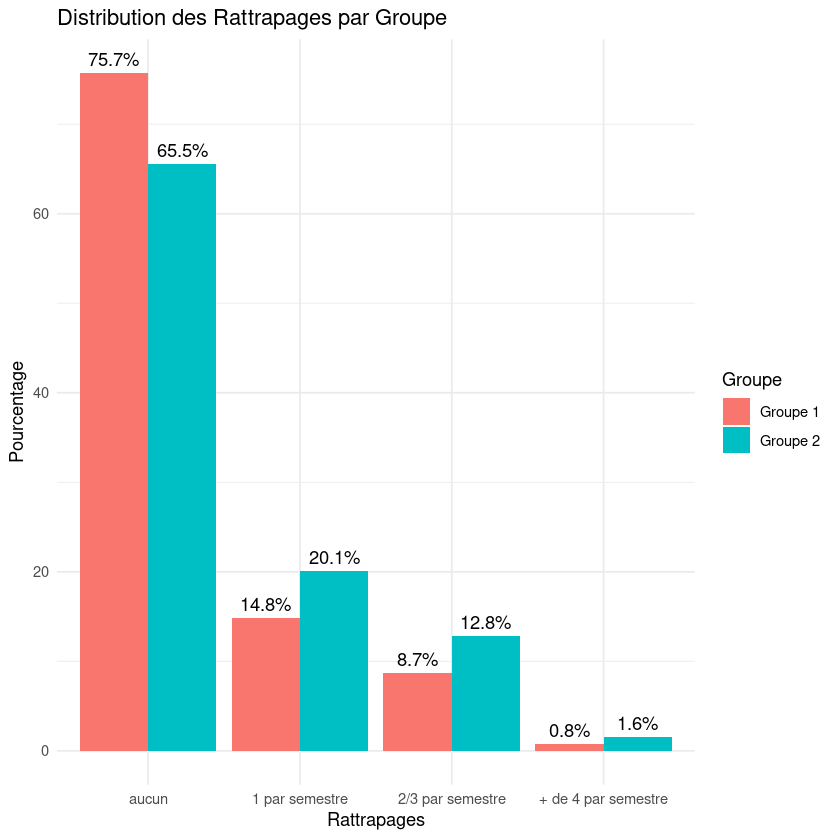

In [12]:
# Convert PROMO and INTEGRATION to character to avoid factor level issues
insa_cleaned_1 <- insa_cleaned_1 %>%
  mutate(PROMO = as.character(PROMO),
         INTEGRATION = as.character(INTEGRATION))
# Créer le Groupe 1 : Etudiants en première année (PROMO = 1A) ou nouveaus entrants (PROMO = INTEGRATION)
group1 <- insa_cleaned_1[insa_cleaned_1$PROMO == '1A' | insa_cleaned_1$PROMO == insa_cleaned_1$INTEGRATION, ]

# Créer le Groupe 2 : Tous les autres
group2 <- insa_cleaned_1[!(insa_cleaned_1$PROMO == '1A' | insa_cleaned_1$PROMO == insa_cleaned_1$INTEGRATION), ]

# Calculer la distribution de 'RATTRAPAGES' pour les deux groupes
group1_distribution <- prop.table(table(group1$RATTRAPAGES)) * 100
group2_distribution <- prop.table(table(group2$RATTRAPAGES)) * 100

# Convertir les distributions en data frames pour les graphiques
group1_df <- as.data.frame(group1_distribution)
group2_df <- as.data.frame(group2_distribution)
group1_df$Group <- 'Groupe 1'
group2_df$Group <- 'Groupe 2'

# Renommer les colonnes pour plus de clarté
colnames(group1_df) <- c("RATTRAPAGES", "Pourcentage", "Groupe")
colnames(group2_df) <- c("RATTRAPAGES", "Pourcentage", "Groupe")

# Combiner les data frames
combined_df <- rbind(group1_df, group2_df)

# Afficher les distributions en utilisant ggplot2
ggplot(combined_df, aes(x = RATTRAPAGES, y = Pourcentage, fill = Groupe)) +
  geom_bar(stat = 'identity', position = 'dodge') +
  geom_text(aes(label = sprintf("%.1f%%", Pourcentage)), 
            position = position_dodge(width = 0.9), vjust = -0.5) +
  labs(title = 'Distribution des Rattrapages par Groupe',
       x = 'Rattrapages',
       y = 'Pourcentage') +
  theme_minimal()

In [13]:
# Créer une table de contingence pour les groupes et les catégories de RATTRAPAGES
contingency_table <- table(insa_cleaned_1$RATTRAPAGES, 
                           ifelse(insa_cleaned_1$PROMO == '1A' | insa_cleaned_1$PROMO == insa_cleaned_1$INTEGRATION, 'Groupe 1', 'Groupe 2'))

# Afficher la table de contingence
print(contingency_table)

# Réaliser le test du Chi-Square
chi_square_test <- chisq.test(contingency_table)

# Afficher les résultats du test
print(chi_square_test)


                     
                      Groupe 1 Groupe 2
  aucun                    296      506
  1 par semestre            58      155
  2/3 par semestre          34       99
  + de 4 par semestre        3       12

	Pearson's Chi-squared test

data:  contingency_table
X-squared = 12.896, df = 3, p-value = 0.004867



p-value = 0.004867 < 0.05 => La distribution des RATTRAPAGES dans le groupe 1 et le groupe 2 est différente.

In [14]:
# Convert PROMO and INTEGRATION to character to avoid factor level issues
insa_cleaned_1 <- insa_cleaned_1 %>%
  mutate(PROMO = as.character(PROMO),
         INTEGRATION = as.character(INTEGRATION))

# Créer le Groupe 1 : PROMO = 1A ou PROMO = INTEGRATION
group1 <- insa_cleaned_1 %>%
  filter(PROMO == '1A' | PROMO == INTEGRATION)

# Créer le Groupe 2 : Tous les autres
group2 <- insa_cleaned_1 %>%
  filter(!(PROMO == '1A' | PROMO == INTEGRATION))

# Afficher les premières lignes des deux dataframes pour vérification
head(group1)
head(group2)

write_xlsx(group1, "group1.xlsx")
write_xlsx(group2, "group2.xlsx")

TRAJET,LOGEMENTTYPE,LOGEMENTSURFACE,LOGEMENTBIEN,ACT_PRO,BOURSIER,HANDICAP,TIERSTEMPS,STRESS,COMMENTAIRE,⋯,PROMO,SPECIALITE,COHORTE,DOUBLEDIPLOME,INTEGRATION,BACTYPE,CLASSEMENT1A,CLASSEMENTDERNIER,REDOUBLEMENT,RATTRAPAGES
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<chr>,<fct>,<fct>,<fct>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>
15-30min,seul,20-30m2,tout à fait,aucune,non,non,Non,toujours,parfois,⋯,3A,GB,classique,non,3A,Fr,pas de classement,jsp,Non,aucun
5-15min,colocation,coloc ou foyer familial,tout à fait,oui 1-5h,non,non,Non,souvent,parfois,⋯,3A,GB,SHN,non,3A,Fr,pas de classement,10-25%,Non,2/3 par semestre
5-15min,seul,20-30m2,plutôt oui,aucune,echelon 1-3,non,Non,toujours,parfois,⋯,3A,ICBE,classique,non,3A,Fr,pas de classement,jsp,Non,aucun
5-15min,seul,20-30m2,plutôt oui,aucune,non,non,Non,toujours,parfois,⋯,3A,ICBE,classique,non,3A,Fr,pas de classement,jsp,Non,aucun
15-30min,seul,20-30m2,tout à fait,aucune,non,non,Non,parfois,jamais,⋯,3A,ICBE,classique,non,3A,Fr,pas de classement,jsp,Non,aucun
5-15min,seul,20-30m2,tout à fait,aucune,non,non,Non,parfois,jamais,⋯,3A,GB,classique,non,3A,Fr,pas de classement,75-100%,Oui,1 par semestre


TRAJET,LOGEMENTTYPE,LOGEMENTSURFACE,LOGEMENTBIEN,ACT_PRO,BOURSIER,HANDICAP,TIERSTEMPS,STRESS,COMMENTAIRE,⋯,PROMO,SPECIALITE,COHORTE,DOUBLEDIPLOME,INTEGRATION,BACTYPE,CLASSEMENT1A,CLASSEMENTDERNIER,REDOUBLEMENT,RATTRAPAGES
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<chr>,<fct>,<fct>,<fct>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>
15-30min,seul,+ 30m2,tout à fait,aucune,echelon 1-3,non,Non,souvent,jamais,⋯,4A,GMM,classique,non,3A,Fr,pas de classement,25-50%,Non,aucun
5-15min,seul,+ 30m2,tout à fait,aucune,non,non,Non,souvent,parfois,⋯,4A,GMM,classique,oui,post-bac,Fr,0-10%,0-10%,Non,aucun
0-5min,seul,10-20m2,plutôt oui,aucune,non,non,Non,souvent,parfois,⋯,4A,GMM,classique,non,1A,Fr,50-75%,25-50%,Non,aucun
5-15min,seul,+ 30m2,tout à fait,aucune,non,non,Non,toujours,parfois,⋯,4A,GB,classique,non,post-bac,Fr,25-50%,10-25%,Non,aucun
5-15min,colocation,coloc ou foyer familial,tout à fait,aucune,non,non,Oui,souvent,parfois,⋯,4A,GB,classique,non,3A,Fr,pas de classement,50-75%,Oui,1 par semestre
5-15min,colocation,coloc ou foyer familial,tout à fait,oui 1-5h,non,non,Non,toujours,parfois,⋯,4A,GB,classique,non,post-bac,Fr,50-75%,jsp,Oui,2/3 par semestre


In [15]:
# Obtenir la liste des variables à partir des noms des colonnes de group1
variables_to_plot <- names(group1)

# Créer une liste pour stocker les graphiques
plots <- list()

# Générer les graphiques pour chaque variable et les ajouter à la liste
for (var in variables_to_plot) {
  plots[[var]] <- plot_distribution(group1, var)
}

# Définir le nombre de colonnes et calculer le nombre de lignes nécessaires
ncol <- 4
nrow <- ceiling(length(plots) / ncol)

# Enregistrer les graphiques dans un fichier PDF
pdf("distributions_group_1.pdf", width = 16, height = nrow * 7)  # Ajustez la largeur et la hauteur selon vos besoins
grid.arrange(grobs = lapply(plots, ggplotGrob), ncol = ncol)
dev.off()

png 
  2

In [16]:
# Obtenir la liste des variables à partir des noms des colonnes de group2
variables_to_plot <- names(group2)

# Créer une liste pour stocker les graphiques
plots <- list()

# Générer les graphiques pour chaque variable et les ajouter à la liste
for (var in variables_to_plot) {
  plots[[var]] <- plot_distribution(group2, var)
}

# Définir le nombre de colonnes et calculer le nombre de lignes nécessaires
ncol <- 4
nrow <- ceiling(length(plots) / ncol)

# Enregistrer les graphiques dans un fichier PDF
pdf("distributions_group_2.pdf", width = 16, height = nrow * 7)  # Ajustez la largeur et la hauteur selon vos besoins
grid.arrange(grobs = lapply(plots, ggplotGrob), ncol = ncol)
dev.off()

png 
  2

In [17]:
# Créer une table de contingence pour LOGEMENTTYPE et RATTRAPAGES
contingency_table <- table(insa_cleaned_1$LOGEMENTTYPE, insa_cleaned_1$RATTRAPAGES)

# Afficher la table de contingence
print(contingency_table)


                
                 aucun 1 par semestre 2/3 par semestre + de 4 par semestre
  seul             611            158               99                  12
  colocation       147             40               26                   1
  foyer familial    44             15                8                   2


In [18]:
# Réaliser le test du Chi-Square
chi_square_test <- chisq.test(contingency_table)

# Afficher les résultats du test
print(chi_square_test)


Warning message in chisq.test(contingency_table):
“L’approximation du Chi-2 est peut-être incorrecte”



	Pearson's Chi-squared test

data:  contingency_table
X-squared = 3.4887, df = 6, p-value = 0.7455



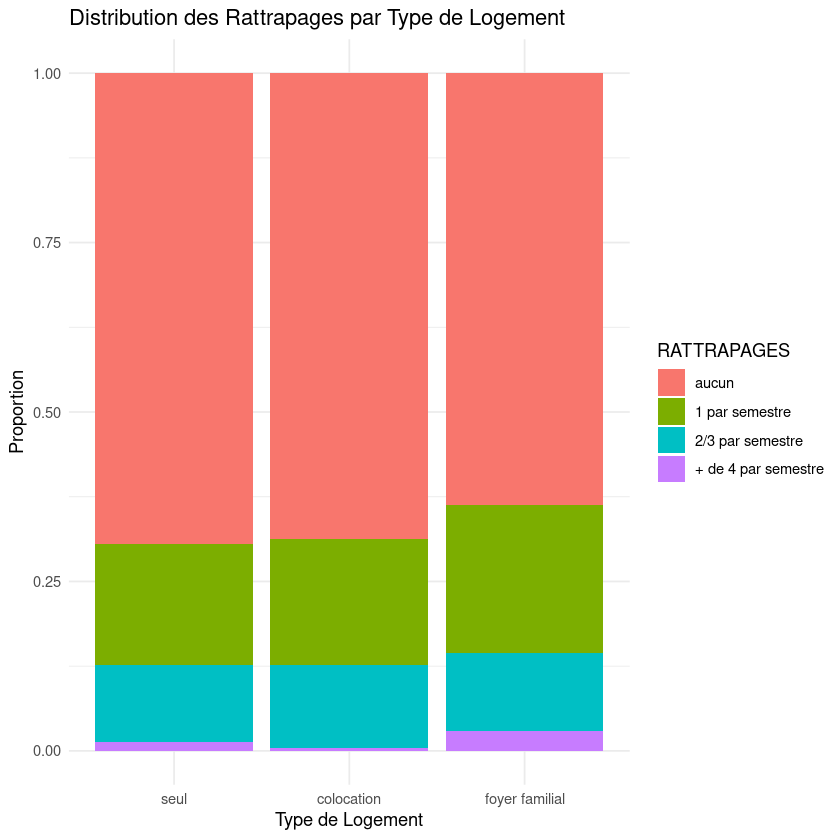

In [19]:
# Visualiser la distribution des RATTRAPAGES par LOGEMENTTYPE
ggplot(insa_cleaned_1, aes(x = LOGEMENTTYPE, fill = RATTRAPAGES)) +
  geom_bar(position = 'fill') +
  labs(title = 'Distribution des Rattrapages par Type de Logement',
       x = 'Type de Logement',
       y = 'Proportion') +
  theme_minimal()


In [41]:
insa1a2a <- insa_cleaned_1 %>%
    filter((PROMO == '1A' | PROMO == '2A') & REDOUBLEMENT == 'non') %>%
    select(PROMO, CLASSEMENTDERNIER)

# Affichage du DataFrame résultant pour vérifier les résultats
print(insa1a2a)

# A tibble: 0 × 2
# ℹ 2 variables: PROMO <fct>, CLASSEMENTDERNIER <fct>


In [19]:
dim(group1)

[1] 391  60

In [23]:
# Set up Monte Carlo cross-validation
set.seed(123)  # For reproducibility
n_iterations <- 100
rf_results <- list()
var_importance_list <- list()

for (i in 1:n_iterations) {
  # Split the data into training (80%) and test (20%) sets
  trainIndex <- createDataPartition(group1$RATTRAPAGES, p = 0.8, 
                                    list = FALSE, 
                                    times = 1)
  trainData <- group1[trainIndex,]
  testData <- group1[-trainIndex,]
  
  # Train the Random Forest model
  rf_model <- randomForest(RATTRAPAGES ~ ., data = trainData, 
                           importance = TRUE, 
                           ntree = 500)
  
  # Make predictions on the test set
  predictions <- predict(rf_model, newdata = testData)
  
  # Evaluate the model using confusion matrix
  conf_matrix <- confusionMatrix(predictions, testData$RATTRAPAGES)
  rf_results[[i]] <- conf_matrix
  
  # Variable importance
  var_importance_list[[i]] <- importance(rf_model)
}


In [20]:
# Combine the results of all iterations
accuracy_list <- sapply(rf_results, function(x) x$overall['Accuracy'])
mean_accuracy <- mean(accuracy_list)
print(paste("Mean accuracy over", n_iterations, "iterations:", mean_accuracy))

# Calculate average variable importance
combined_importance <- Reduce("+", var_importance_list) / n_iterations
varImportance <- data.frame(Variables = row.names(combined_importance), 
                            Importance = round(combined_importance[, "MeanDecreaseGini"], 2))

# Create a plot for variable importance
ggplot(varImportance, aes(x = reorder(Variables, Importance), y = Importance)) +
  geom_bar(stat = 'identity') +
  coord_flip() +
  xlab('Variables') +
  ylab('Importance') +
  ggtitle('Average Variable Importance from Random Forest Model (Monte Carlo CV)')

ERROR: Error in eval(expr, envir, enclos): objet 'rf_results' introuvable


    Cependant, je vois un autre problème ici : nous avons des modalités avec des fréquences d'apparition très faibles, par exemple pour les variables LOGEMENTBIEN, ACT_PRO(TRAVAILTEMPS), COMCONSTRUCTIFS(NON), PRESENCE_TD,... Cela rend les estimations des paramètres de ces modalités très instables, entraînant du bruit et un surajustement du modèle. Par conséquent, la mise en commun augmente le nombre d'observations par groupe, aidant ainsi le modèle à apprendre des modèles de manière plus cohérente. De plus, regrouper les variables avec une fréquence faible mais des significations similaires aide à réduire la complexité du modèle, car chaque modalité dans une variable catégorielle crée une nouvelle dimension spatiale lorsqu’elle est codée à l’aide de la méthode de codage one-hot, entraînant une augmentation du nombre de paramètres à apprendre et un risque accru de surajustement.
    Par exemple, si nous avons seulement un étudiant qui choisit SORTIEBAR_tous les jours, et que cet étudiant redouble, nous risquons un surajustement car les variables REDOUBLEMENT et SORTIEBAR_tous les jours seraient complètement corrélées.

    Après avoir combiné les modalités à faible fréquence et de signification similaire, nos données seront entièrement propres et prêtes pour la construction du modèle.

 Le choix du modèle pour l'analyse, nous allons utiliser la méthode Random Forest, car elle n'est pas affectée par la dépendance entre les variables. 

In [36]:
insa1_selected <- insa1 %>%
  select(ID,PROMO, INTEGRATION,`RATTRAPAGES[other]`) %>%
  filter(!is.na(`RATTRAPAGES[other]`))

write_xlsx(insa1_selected, "insa_recoder_rattrapages.xlsx")
